## run a field-level IMNN on simulations with noise

In [1]:
cd imnn_scripts/

/home/makinen/repositories/wl-sbi/imnn_scripts


/home/makinen/venvs/lemur/lib64/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import math
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import optax
import matplotlib.pyplot as plt
from functools import partial
import flax.linen as nn

import jax.random as jr

import cloudpickle as pickle


np = jnp

from imnns import *

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)
        
def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)


%load_ext autoreload
%autoreload 2

### info-update imnn

In [3]:
from imnns import _check_input
from progress_bar import *


class _updateIMNN:

    def __init__(self, n_s, n_d, n_params, n_summaries, input_shape, θ_fid,
                 model, optimiser, key_or_state, 
                 existing_statistic=None,
                 dummy_graph_input=None, 
                 no_invC=False, 
                 do_reg=True,
                 evidence=False):
        
        self.dummy_graph_input=dummy_graph_input
        self.existing_statistic = existing_statistic
        self._initialise_parameters(
            n_s, n_d, n_params, n_summaries, input_shape, θ_fid)
        self._initialise_model(model, optimiser, key_or_state)
        self._initialise_history()
        self.no_invC=no_invC
        self.do_reg=do_reg
        self.evidence=evidence


    def _initialise_parameters(self, n_s, n_d, n_params, n_summaries,
                               input_shape, θ_fid):
        
        self.n_s = n_s 
        self.n_d = n_d
        self.n_params = n_params
        self.n_summaries = n_summaries
        self.input_shape = input_shape
        self.θ_fid = θ_fid

        self.validate = False
        self.simulate = False
        self._run_with_pbar = False
        self._run_without_pbar = False

        self.F = None
        self.invF = None
        self.C = None
        self.invC = None
        self.μ = None
        self.dμ_dθ = None

        self._model_initialiser = None
        self.model = None
        self._opt_initialiser = None
        self._update = None
        self._get_parameters = None
        self.state = None
        self.initial_w = None
        self.final_w = None
        self.best_w = None
        self.w = None

        self.history = None

        if self.existing_statistic:
            self._get_existing_stats(self.existing_statistic)

    def _initialise_model(self, model, optimiser, key_or_state):

        # initialize FLAX model here
        self._model_initialiser = model.init
        self.model = model.apply

        # unpack optimiser
        self._opt_initialiser, self._update = optimiser

        #state, key = _check_state(key_or_state)
        key = key_or_state

        if key is not None:
            key = key #_check_input(key, (2,), "key_or_state")
            if self.dummy_graph_input is None:
                dummy_x = jax.random.uniform(key, self.input_shape)
            else:
                dummy_x = self.dummy_graph_input

            # INITIAL PARAMS
            self.initial_w = self._model_initialiser(key, dummy_x)
            
            # DUMMY OUTPUT
            output = self.model(self.initial_w, dummy_x)
            # check to see if right shape
            # check_model_output(output.shape, (self.n_summaries,))
            # INITIAL STATE
            self.state = self._opt_initialiser(self.initial_w)


        else:
            self.state = state
            try:
                self._get_parameters(self.state)
            except Exception:
                raise TypeError("`state` is not valid for extracting " +
                                "parameters from")

        self.dummy_x = dummy_x
        self.initial_w = self._model_initialiser(key, dummy_x)
        self.final_w = self._model_initialiser(key, dummy_x)
        self.best_w = self._model_initialiser(key, dummy_x)
        self.w = self._model_initialiser(key, dummy_x)


    def _initialise_history(self):

        self.history = {
            "detF": np.zeros((0,)),
            "detC": np.zeros((0,)),
            "detinvC": np.zeros((0,)),
            "Λ2": np.zeros((0,)),
            "r": np.zeros((0,)),
            "val_detF": np.zeros((0,)),
            "val_detC": np.zeros((0,)),
            "val_detinvC": np.zeros((0,)),
            "val_Λ2": np.zeros((0,)),
            "val_r": np.zeros((0,)),
            "max_detF": np.float32(0.)
        }

    def _set_history(self, results):
        keys = ["detF", "detC", "detinvC", "Λ2", "r"]
        for result, key in zip(results, keys):
            self.history[key] = np.hstack([self.history[key], result[:, 0]])
            if self.validate:
                self.history[f"val_{key}"] = np.hstack(
                    [self.history[f"val_{key}"], result[:, 1]])

    def _set_inputs(self, rng, max_iterations):

        if self.validate:
            shape = (max_iterations, 2)
        else:
            shape = (max_iterations, 1)

        return (
            self.history["max_detF"], self.best_w, np.zeros(shape),
            np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(shape),
            np.int32(0), np.int32(0), self.state, self.w, rng)

    def fit(self, λ, ϵ, γ=1000., rng=None, patience=100, min_iterations=100,
            max_iterations=int(1e5), print_rate=None, best=True):

        @jax.jit
        def _fit(inputs):

            return jax.lax.while_loop(
                partial(self._fit_cond, patience=patience,
                        max_iterations=max_iterations),
                partial(self._fit, λ=λ, α=α, γ=γ, min_iterations=min_iterations),
                inputs)

        def _fit_pbar(inputs):

            return jax.lax.while_loop(
                progress_bar(max_iterations, patience, print_rate)(
                    partial(self._fit_cond, patience=patience,
                            max_iterations=max_iterations)),
                jax.jit(
                    partial(self._fit, λ=λ, α=α,  γ=γ,
                            min_iterations=min_iterations)),
                inputs)

        λ = λ 
        ϵ = ϵ 
        γ = γ 
        α = self.get_α(λ, ϵ)
        patience = patience 
        min_iterations = min_iterations 
        max_iterations = max_iterations 
        best = best
        if self.simulate and (rng is None):
            raise ValueError("`rng` is necessary when simulating.")
        rng = rng
        inputs = self._set_inputs(rng, max_iterations)
        if print_rate is None:
            if self._run_with_pbar:
                raise ValueError(
                    "Cannot run IMNN without progress bar after running " +
                    "with progress bar. Either set `print_rate` to an int " +
                    "or reinitialise the IMNN.")
            else:
                self._run_without_pbar = True
                results = _fit(inputs)
        else:
            if self._run_without_pbar:
                raise ValueError(
                    "Cannot run IMNN with progress bar after running " +
                    "without progress bar. Either set `print_rate` to None " +
                    "or reinitialise the IMNN.")
            else:
                print_rate = print_rate # _check_type(print_rate, int, "print_rate")
                self._run_with_pbar = True
                results = _fit_pbar(inputs)
        self.history["max_detF"] = results[0]
        self.best_w = results[1]
        self._set_history(
            (results[2][:results[7]],
             results[3][:results[7]],
             results[4][:results[7]],
             results[5][:results[7]],
             results[6][:results[7]]))
        if len(results) == 12:
            self.state = results[-3]
        self.final_w = results[-2] #self._get_parameters(self.state)
        if best:
            w = self.best_w
        else:
            w = self.final_w
        self.set_F_statistics(w, key=rng)

    def _get_fitting_keys(self, rng):
        if rng is not None:
            return jax.random.split(rng, num=3)
        else:
            return None, None, None

    def get_α(self, λ, ϵ):
        return - math.log(ϵ * (λ - 1.) + ϵ ** 2. / (1 + ϵ)) / ϵ

    #@progress_bar_scan(num_samples)
    def _fit(self, inputs, λ=None, α=None, γ=None,  min_iterations=None):

        max_detF, best_w, detF, detC, detinvC, Λ2, r, \
            counter, patience_counter, state, w, rng = inputs
        rng, training_key, validation_key = self._get_fitting_keys(rng)


        grad, results = jax.grad(
            self._get_loss, argnums=0, has_aux=True)(w, λ, α, γ, training_key)

        #if self.pass_params:
        updates, state = self._update(grad, state, w)

        w = optax.apply_updates(w, updates) # UPDATE PARAMS

        detF, detC, detinvC, Λ2, r = self._update_history(
            results, (detF, detC, detinvC, Λ2, r), counter, 0)
        if self.validate:
            F, C, invC, *_ = self._get_F_statistics(
                w, key=validation_key, validate=True)
            _Λ2 = self._get_regularisation(C, invC)
            _r = self._get_regularisation_strength(_Λ2, λ, α)
            results = (F, C, invC, _Λ2, _r)
            detF, detC, detinvC, Λ2, r = self._update_history(
                results, (detF, detC, detinvC, Λ2, r), counter, 1)
        _detF = np.linalg.det(results[0])
        patience_counter, counter, _, max_detF, __, best_w = \
            jax.lax.cond(
                np.greater(_detF, max_detF),
                self._update_loop_vars,
                lambda inputs: self._check_loop_vars(inputs, min_iterations),
                (patience_counter, counter, _detF, max_detF, w, best_w))
        return (max_detF, best_w, detF, detC, detinvC, Λ2, r,
                counter + np.int32(1), patience_counter, state, w, rng)

    def _fit_cond(self, inputs, patience, max_iterations):
        return np.logical_and(
            np.less(inputs[-4], patience),
            np.less(inputs[-5], max_iterations))

    def _update_loop_vars(self, inputs):
        patience_counter, counter, detF, max_detF, w, best_w = inputs
        return (np.int32(0), counter, detF, detF, w, w)

    def _check_loop_vars(self, inputs, min_iterations):
        patience_counter, counter, detF, max_detF, w, best_w = inputs
        patience_counter = jax.lax.cond(
            np.greater(counter, min_iterations),
            lambda patience_counter: patience_counter + np.int32(1),
            lambda patience_counter: patience_counter,
            patience_counter)
        return (patience_counter, counter, detF, max_detF, w, best_w)

    def _update_history(self, inputs, history, counter, ind):
        F, C, invC, _Λ2, _r = inputs
        detF, detC, detinvC, Λ2, r = history
        detF = detF.at[counter, ind].set(np.linalg.det(F))
        detC = detC.at[counter, ind].set(np.linalg.det(C))
        detinvC = detinvC.at[counter, ind].set(np.linalg.det(invC))
        Λ2 = Λ2.at[counter, ind].set(_Λ2)
        r = r.at[counter, ind].set(_r)
        return detF, detC, detinvC, Λ2, r


    # INFORMATION UPDATE STUFF
    def _get_existing_stats(self, existing_statistic):
        # if not self.existing_statistic:
        #     raise ValueError(
        #             "This IMNN has not been initialised as an information-update " +
        #             "IMNN. Pleasereinitialise the IMNN with an existing statistic.")
        # else:
        self.n_t = existing_statistic["n_t"]
        self.μ_t = existing_statistic["mean_derivatives"]
        self.C_t = existing_statistic["covariance"]
        self.C_t_inv = np.linalg.inv(self.C_t)
        self.F_t = existing_statistic["Fisher"]
        self.summaries_t = existing_statistic["fid_summaries"] # could also pass a function to get these from fiducial ?
        
        

    def _slogdet(self, matrix):
        lndet = np.linalg.slogdet(matrix)
        return lndet[0] * lndet[1]

    def _construct_derivatives(self, derivatives):
        return derivatives

    def set_F_statistics(self, w=None, key=None, validate=True):

        if validate and ((not self.validate) and (not self.simulate)):
            validate = False
        if w is not None:
            self.w = w
        self.F, self.C, self.invC, self.dμ_dθ, self.μ, self.F_loss = \
            self._get_F_statistics(key=key, validate=validate)
        self.invF = np.linalg.inv(self.F)

    def _get_F_statistics(self, w=None, key=None, validate=False):
        
        if w is None:
            w = self.w
        summaries, derivatives = self.get_summaries(
            w=w, key=key, validate=validate)
        return self._calculate_F_statistics(summaries, derivatives)

    @partial(jax.jit, static_argnums=0)
    def _calculate_F_statistics(self, summaries, derivatives):
        derivatives = self._construct_derivatives(derivatives)
        μ = np.mean(summaries, axis=0)
        C = np.cov(summaries, rowvar=False)
        if self.n_summaries == 1:
            C = np.array([[C]])
        invC = np.linalg.inv(C)

        if self.no_invC:
            invC_loss = np.eye(self.n_summaries)
        else:
            invC_loss = invC
            
        dμ_dθ = np.mean(derivatives, axis=0)

        # NOW DO INFORMATION UPDATE OPTION
        if self.existing_statistic is not None:
            # calculate covariance between imnn summaries and existing summaries
            u = np.cov(self.summaries_t[:self.n_s], summaries, rowvar=False)
            u = u[:self.n_t, self.n_t:] # lower block diagonal vector TODO: CHECK THIS SHAPE IN EINSUM
            
            Λ_info = dμ_dθ - np.einsum("ij,jk,kl->il", self.μ_t, self.C_t_inv, u)
            Σ = C - jnp.einsum("ji,jk,kl->il", u, self.C_t_inv, u)
            invΣ = np.linalg.inv(Σ)
            F = self.F_t + np.einsum("ij,jk,lk->il", Λ_info, invΣ, Λ_info)
            F_loss = F

            # TODO: CHECK THIS
            #C = Σ
            #invC = invΣ

        else:
            F = np.einsum("ij,ik,kl->jl", dμ_dθ, invC, dμ_dθ)
            F_loss = np.einsum("ij,ik,kl->jl", dμ_dθ, invC_loss, dμ_dθ)

        
        return (F, C, invC, dμ_dθ, μ, F_loss)

    @partial(jax.jit, static_argnums=0)
    def _get_regularisation_strength(self, Λ2, λ, α):
        return λ * Λ2 / (Λ2 + np.exp(-α * Λ2))

    @partial(jax.jit, static_argnums=0)
    def _get_regularisation(self, C, invC):
        if self.no_invC:
            if self.evidence:
                #reg = -(np.log(np.linalg.det(C)) - np.trace(C) + self.n_params)
                reg = np.trace(C)
            else:
                reg = np.linalg.norm(C - np.eye(self.n_summaries))

        else:
            reg = np.linalg.norm(C - np.eye(self.n_summaries)) + \
                np.linalg.norm(invC - np.eye(self.n_summaries))
        return reg

    def _get_loss(self, w, λ, α, γ, key=None):
        summaries, derivatives = self.get_summaries(w=w, key=key)
        return self._calculate_loss(summaries, derivatives, λ, α, γ)

    def _calculate_loss(self, summaries, derivatives, λ, α, γ):
        F, C, invC, dμ_dθ, _, F_loss = self._calculate_F_statistics(
            summaries, derivatives)
        lndetF = self._slogdet(F_loss)
        Λ2 = self._get_regularisation(C, invC)
        if self.do_reg:
            r = self._get_regularisation_strength(Λ2, λ, α)
        else:
            r = γ*0.5
        return - lndetF + r * Λ2, (F, C, invC, Λ2, r)

    def get_summaries(self, w=None, key=None, validate=False):
        raise ValueError("`get_summaries` not implemented")

    def get_estimate(self, d):

        @jax.jit
        def single_element(d):
            return self.θ_fid + np.einsum(
                "ij,kj,kl,l->i",
                self.invF,
                self.dμ_dθ,
                self.invC,
                self.model(self.w, d) - self.μ)

        @jax.jit
        def multiple_elements(d):

            def fn(d):
                return self.model(self.w, d)
            return self.θ_fid + np.einsum(
                "ij,kj,kl,ml->mi",
                self.invF,
                self.dμ_dθ,
                self.invC,
                jax.vmap(fn)(d) - self.μ)

        #_check_statistics_set(self.invF, self.dμ_dθ, self.invC, self.μ)
        # check shape: array or graph ?
        if self.dummy_graph_input is None:
          if len(d.shape) == 1:
              return single_element(d)
          else:
              return multiple_elements(d)
        else:
            return single_element(d)

    def _setup_plot(self, ax=None, expected_detF=None, figsize=(5, 15)):

        if ax is None:
            fig, ax = plt.subplots(3, 1, sharex=True, figsize=figsize)
            plt.subplots_adjust(hspace=0.05)
        ax = [x for x in ax] + [ax[2].twinx()]
        if expected_detF is not None:
            ax[0].axhline(expected_detF, linestyle="dashed", color="black")
        ax[0].set_ylabel(r"$|{\bf F}|$")
        ax[1].axhline(1, linestyle="dashed", color="black")
        ax[1].set_ylabel(r"$|{\bf C}|$ and $|{\bf C}^{-1}|$")
        ax[1].set_yscale("log")
        ax[2].set_xlabel("Number of iterations")
        ax[2].set_ylabel(r"$\Lambda_2$")
        ax[3].set_ylabel(r"$r$")
        return ax

    def plot(self, ax=None, expected_detF=None, colour="C0", figsize=(5, 15),
             label="", filename=None, ncol=1):

        if ax is None:
            ax = self._setup_plot(expected_detF=expected_detF, figsize=figsize)
        ax[0].set_xlim(
            0, max(self.history["detF"].shape[0] - 1, ax[0].get_xlim()[-1]))
        ax[0].plot(self.history["detF"], color=colour,
                   label=r"{} $|F|$ (training)".format(label))
        ax[1].set_xlim(
            0, max(self.history["detF"].shape[0] - 1, ax[0].get_xlim()[-1]))
        ax[1].plot(self.history["detC"], color=colour,
                   label=r"{} $|C|$ (training)".format(label))
        ax[1].plot(self.history["detinvC"], linestyle="dotted", color=colour,
                   label=label + r" $|C^{-1}|$ (training)")
        ax[3].set_xlim(
            0, max(self.history["detF"].shape[0] - 1, ax[0].get_xlim()[-1]))
        ax[2].plot(self.history["Λ2"], color=colour,
                   label=r"{} $\Lambda_2$ (training)".format(label))
        ax[3].plot(self.history["r"], color=colour, linestyle="dashed",
                   label=r"{} $r$ (training)".format(label))
        if self.validate:
            ax[0].plot(self.history["val_detF"], color=colour,
                       label=r"{} $|F|$ (validation)".format(label),
                       linestyle="dotted")
            ax[1].plot(self.history["val_detC"], color=colour,
                       label=r"{} $|C|$ (validation)".format(label),
                       linestyle="dotted")
            ax[1].plot(self.history["val_detinvC"],
                       color=colour,
                       label=label + r" $|C^{-1}|$ (validation)",
                       linestyle="dashdot")
            ax[2].plot(self.history["val_Λ2"], color=colour,
                       label=r"{} $\Lambda_2$ (validation)".format(label),
                       linestyle="dotted")
            ax[3].plot(self.history["val_r"], color=colour,
                       label=r"{} $r$ (validation)".format(label),
                       linestyle="dashdot")
        h1, l1 = ax[2].get_legend_handles_labels()
        h2, l2 = ax[3].get_legend_handles_labels()
        ax[0].legend(bbox_to_anchor=(1.0, 1.0), frameon=False, ncol=ncol)
        ax[1].legend(frameon=False, bbox_to_anchor=(1.0, 1.0), ncol=ncol * 2)
        ax[3].legend(h1 + h2, l1 + l2, bbox_to_anchor=(1.05, 1.0),
                     frameon=False, ncol=ncol * 2)

        if filename is not None:
            plt.savefig(filename, bbox_inches="tight", transparent=True)
        return ax




##### NUM GRAD IMNN #####
## PUT IN NOISE NUMERICAL GRAD IMNN

class NumericalGradientIMNN(_updateIMNN):
    """Information maximising neural network fit using numerical derivatives
    """
    def __init__(self, n_s, n_d, n_params, n_summaries, input_shape, θ_fid,
                 model, optimiser, key_or_state, fiducial, derivative, δθ,
                 validation_fiducial=None, validation_derivative=None, 
                    existing_statistic=None,
                 dummy_graph_input=None,
                 no_invC=False, do_reg=True, evidence=False):

        super().__init__(
            n_s=n_s,
            n_d=n_d,
            n_params=n_params,
            n_summaries=n_summaries,
            input_shape=input_shape,
            θ_fid=θ_fid,
            model=model,
            key_or_state=key_or_state,
            optimiser=optimiser,
            existing_statistic=existing_statistic,
            dummy_graph_input=dummy_graph_input,
            no_invC=no_invC,
            do_reg=do_reg,
            evidence=evidence)
        self._set_data(δθ, fiducial, derivative, validation_fiducial,
                       validation_derivative)
        self.dummy_graph_input = dummy_graph_input

    def _set_data(self, δθ, fiducial, derivative, validation_fiducial,
                  validation_derivative):
        self.δθ = np.expand_dims(
            _check_input(δθ, (self.n_params,), "δθ"), (0, 1))
        if self.dummy_graph_input is None:
          self.fiducial = _check_input(
              fiducial, (self.n_s,) + self.input_shape, "fiducial")
          self.derivative = _check_input(
              derivative, (self.n_d, 2, self.n_params) + self.input_shape,
              "derivative")
          if ((validation_fiducial is not None)
                  and (validation_derivative is not None)):
              self.validation_fiducial = _check_input(
                  validation_fiducial, (self.n_s,) + self.input_shape,
                  "validation_fiducial")
              self.validation_derivative = _check_input(
                  validation_derivative,
                  (self.n_d, 2, self.n_params) + self.input_shape,
                  "validation_derivative")
              self.validate = True
        else:
          self.fiducial = fiducial
          self.derivative = derivative

          if ((validation_fiducial is not None)
                  and (validation_derivative is not None)):
              self.validation_fiducial = validation_fiducial
              self.validation_derivative =  validation_derivative
              self.validate = True


    def _collect_input(self, key, validate=False):
        if validate:
            fiducial = self.validation_fiducial
            derivative = self.validation_derivative
        else:
            fiducial = self.fiducial
            derivative = self.derivative
        return fiducial, derivative

    def get_summaries(self, w, key=None, validate=False):
        
        d, d_mp = self._collect_input(key, validate=validate)
        
        
        if self.dummy_graph_input is None:
          _model = lambda d: self.model(w, d)
          x = jax.vmap(_model)(d)
          x_mp = np.reshape(
              jax.vmap(_model)(
                    d_mp.reshape(
                      (self.n_d * 2 * self.n_params,) + self.input_shape)),
              (self.n_d, 2, self.n_params, self.n_summaries))
        else:
          # if operating on graph data, we need to vmap the implicit
          # batch dimension
          _model = lambda d: self.model(w, d)
          x = jax.vmap(_model)(d)
          x_mp = np.reshape(
              jax.vmap(_model)(d_mp),
              (self.n_d, 2, self.n_params, self.n_summaries))

        return x, x_mp

    def _construct_derivatives(self, x_mp):
        return np.swapaxes(x_mp[:, 1] - x_mp[:, 0], 1, 2) / self.δθ





# NOISE NUMERICAL GRADIENT IMNN
class NoiseNumericalGradientIMNN(_updateIMNN):
    """Information maximising neural network fit with simulations on-the-fly
    """
    def __init__(self, n_s, n_d, n_params, n_summaries, input_shape, θ_fid, δθ,
                 model, optimiser, key_or_state,
                 noise_simulator, 
                 fiducial, derivative,
                 validation_fiducial=None, validation_derivative=None, 
                 existing_statistic=None,
                 dummy_graph_input=None,
                 no_invC=False, do_reg=True,
                 evidence=False):
        """Constructor method

        Initialises all IMNN attributes, constructs neural network and its
        initial parameter values and creates history dictionary. Also checks
        validity of simulator and sets the ``simulate`` attribute to ``True``.

        Parameters
        ----------
        n_s : int
            Number of simulations used to calculate summary covariance
        n_d : int
            Number of simulations used to calculate mean of summary derivative
        n_params : int
            Number of model parameters
        n_summaries : int
            Number of summaries, i.e. outputs of the network
        input_shape : tuple
            The shape of a single input to the network
        θ_fid : float(n_params,)
            The value of the fiducial parameter values used to generate inputs
        model : tuple, len=2
            Tuple containing functions to initialise neural network
            ``fn(rng: int(2), input_shape: tuple) -> tuple, list`` and the
            neural network as a function of network parameters and inputs
            ``fn(w: list, d: float(None, input_shape)) -> float(None, n_summari
            es)``.
            (Essentibly stax-like, see `jax.experimental.stax <https://jax.read
            thedocs.io/en/stable/jax.experimental.stax.html>`_))
        optimiser : tuple, len=3
            Tuple containing functions to generate the optimiser state
            ``fn(x0: list) -> :obj:state``, to update the state from a list of
            gradients ``fn(i: int, g: list, state: :obj:state) -> :obj:state``
            and to extract network parameters from the state
            ``fn(state: :obj:state) -> list``.
            (See `jax.experimental.optimizers <https://jax.readthedocs.io/en/st
            able/jax.experimental.optimizers.html>`_)
        key_or_state : int(2) or :obj:state
            Either a stateless random number generator or the state object of
            an preinitialised optimiser
        simulator : fn
            A function that generates a single simulation from a random number
            generator and a tuple (or array) of parameter values at which to
            generate the simulations. For the purposes of use in LFI/ABC
            afterwards it is also useful for the simulator to be able to
            broadcast to a batch of simulations on the zeroth axis
            ``fn(int(2,), float([None], n_params)) ->
            float([None], input_shape)``
        dummy_graph_input : jraph.GraphsTuple or 'jax.numpy.DeviceArray'
            Either a (padded) graph input or device array. If supplied ignores 
            `input_shape` parameter
        """
        super().__init__(
            n_s=n_s,
            n_d=n_d,
            n_params=n_params,
            n_summaries=n_summaries,
            input_shape=input_shape,
            θ_fid=θ_fid,
            model=model,
            optimiser=optimiser,
            key_or_state=key_or_state,
            existing_statistic=existing_statistic,
            dummy_graph_input=dummy_graph_input,
            no_invC=no_invC,
            do_reg=do_reg,
            evidence=evidence)

        self.existing_statistic = existing_statistic
        self.simulator = noise_simulator
        #self.simulate = True
        self.dummy_graph_input = dummy_graph_input
        self.θ_der = (θ_fid + np.einsum("i,jk->ijk", np.array([-1., 1.]), 
                                        np.diag(δθ) / 2.)).reshape((-1, 2))
        self.δθ = np.expand_dims(
            _check_input(δθ, (self.n_params,), "δθ"), (0, 1))
        
        # NUMERICAL GRADIENT SETUP
        self._set_data(δθ, fiducial, derivative, validation_fiducial,
                       validation_derivative)


    def _set_data(self, δθ, fiducial, derivative, validation_fiducial,
                  validation_derivative):
        """Checks and sets data attributes with the correct shape
        """
        self.δθ = np.expand_dims(
            _check_input(δθ, (self.n_params,), "δθ"), (0, 1))
        if self.dummy_graph_input is None:
          self.fiducial = _check_input(
              fiducial, (self.n_s,) + self.input_shape, "fiducial")
          self.derivative = _check_input(
              derivative, (self.n_d, 2, self.n_params) + self.input_shape,
              "derivative")
          if ((validation_fiducial is not None)
                  and (validation_derivative is not None)):
              self.validation_fiducial = _check_input(
                  validation_fiducial, (self.n_s,) + self.input_shape,
                  "validation_fiducial")
              self.validation_derivative = _check_input(
                  validation_derivative,
                  (self.n_d, 2, self.n_params) + self.input_shape,
                  "validation_derivative")
              self.validate = True
        else:
          self.fiducial = fiducial
          self.derivative = derivative

          if ((validation_fiducial is not None)
                  and (validation_derivative is not None)):
              self.validation_fiducial = validation_fiducial
              self.validation_derivative =  validation_derivative
              self.validate = True


    def _collect_input(self, key, validate=False):
        """ Returns validation or fitting sets
        """
        if validate:
            fiducial = self.validation_fiducial
            derivative = self.validation_derivative
        else:
            fiducial = self.fiducial
            derivative = self.derivative
            
        # add noise to data and make cuts
        keys = np.array(jax.random.split(key, num=self.n_s))
        fiducial = jax.vmap(self.simulator)(keys, fiducial)
        
        _shape = derivative.shape
        derivative = jax.vmap(self.simulator)(
                np.repeat(keys[:self.n_d], 2*self.n_params, axis=0),
                derivative.reshape(
                      (self.n_d * 2 * self.n_params,) + self.input_shape)).reshape(_shape)
                      
        return fiducial, derivative

    def _get_fitting_keys(self, rng):
        """Generates random numbers for simulation

        Parameters
        ----------
        rng : int(2,)
            A random number generator

        Returns
        -------
        int(2,), int(2,), int(2,)
            A new random number generator and random number generators for
            fitting (and validation)
        """
        return jax.random.split(rng, num=3)

    def get_summaries(self, w, key=None, validate=False):
        """Gets all network outputs and derivatives wrt model parameters
        """
        d, d_mp = self._collect_input(key, validate=validate)
        
        
        if self.dummy_graph_input is None:
          _model = lambda d: self.model(w, d)
          x = jax.vmap(_model)(d)
          x_mp = np.reshape(
              jax.vmap(_model)(
                    d_mp.reshape(
                      (self.n_d * 2 * self.n_params,) + self.input_shape)),
              (self.n_d, 2, self.n_params, self.n_summaries))

        else:
          # if operating on graph data, we need to vmap the implicit
          # batch dimension
          _model = lambda d: self.model(w, d)
          x = jax.vmap(_model)(d)
          x_mp = np.reshape(
              jax.vmap(_model)(d_mp),
              (self.n_d, 2, self.n_params, self.n_summaries))

        return x, x_mp

    def _construct_derivatives(self, x_mp):
        """Builds derivatives of the network outputs wrt model parameters
        """
        return np.swapaxes(x_mp[:, 1] - x_mp[:, 0], 1, 2) / self.δθ



### pull in simulations and compute MOPED for Cls

In [4]:
from lemur import analysis, background, cosmology, limber, simulate, plot, utils, constants
from moped import *

def indices_vector(num_tomo):
   indices = []
   cc = 0
   for catA in range(0,num_tomo,1):
      for catB in range(catA,num_tomo,1):
        indices.append([catA, catB])
        cc += 1
   return indices

cl_cut = 15 # 29
skip = 1
num_tomo = 4
Lgrid = (500, 500, 5500)
Nmesh = (128,128,512)
num_bins = jnp.ones(Nmesh[0]//2)[:cl_cut:skip].shape[0]
chi_grid = (jnp.arange(Nmesh[2]) + 0.5) * Lgrid[2] / Nmesh[2]
chi_source = chi_grid[-1]
indices = jnp.array(indices_vector(num_tomo))

def get_spec(index, tomo_data):
    return analysis.compute_auto_cross_angular_power_spectrum(tomo_data[index[0]], tomo_data[index[1]],
                                                chi_source, Lgrid[0])[1][:cl_cut:skip]

def cls_allbins(tomo_data):
    gps = lambda i: get_spec(i, tomo_data)
    return jax.vmap(gps)(indices)


In [5]:
from tqdm import tqdm as tq

### ------------- IMNN PARAMETERS -------------
θ_fid = jnp.array([0.3, 0.800]) # CHANGE TO OmegaM=0.6
δθ = 2*jnp.array([0.0115, 0.015])

θ_der = (θ_fid + jnp.einsum("i,jk->ijk", jnp.array([-1., 1.]), jnp.diag(δθ) / 2.)).reshape((-1, 2))


n_summaries = 2

n_s = 1500
n_d = 125

n_params = 2
n_summaries = n_params
print(θ_der)

z_means_analysis = jnp.array([0.5, 1.0, 1.5, 2.0])
N = 128
L = Lgrid[0]
lpt_order = 2
outdir = "/data101/makinen/lemur_sims/first_analysis/"


fid = jnp.load(outdir + "fid_tomo_L_%d_N_%d_Nz_512_LPT%d.npy"%(L, N, lpt_order))
derv = jnp.load(outdir + "derv_tomo_L_%d_N_%d_Nz_512_LPT%d.npy"%(L, N, lpt_order))


# ----- DO MOPED WITH ALL SIMS (NOISEFREE) -----
fid_cls = []
batch = 50
for i in tq(range(fid.shape[0] // batch)):
    f_ = jax.vmap(cls_allbins)(fid[i*batch:(i+1)*batch]).reshape(-1, len(indices)*(num_bins))
    fid_cls.append(f_)

fid_cls = jnp.concatenate(fid_cls)

derv_cls = []
batch = 50
for i in tq(range(1000 // batch)):
    d_  = jax.vmap(cls_allbins)(derv.reshape(-1, num_tomo, Nmesh[0], Nmesh[1])[i*batch:(i+1)*batch]) 
    derv_cls.append(d_)

derv_cls = jnp.concatenate(derv_cls).reshape(n_d*2, 2, n_params, len(indices)*(num_bins))
# ----- -----


# now initialise MOPED object


[[0.2885 0.8   ]
 [0.3    0.785 ]
 [0.3115 0.8   ]
 [0.3    0.815 ]]


100%|██████████| 20/20 [00:00<00:00, 60.57it/s]


In [6]:
mymoped = MOPED(n_param=2, n_d=n_d*2, n_s=n_s*2, 
                input_shape=fid_cls[0].shape, 
                fiducial=fid_cls, 
                derivatives=derv_cls, 
                δθ=δθ, 
                θ_fid=θ_fid
               )

moped_summs = mymoped.compress(fid_cls)

# next we're going to do a second moped compression to get the derivatives into a smaller space.
# you can check to see that the fisher is the same for both !
mymoped2 = MOPED(
                n_param=2, n_d=n_d*2, n_s=n_s*2, 
                input_shape=(2,), 
                fiducial=mymoped.compress(fid_cls), 
                derivatives=mymoped.compress(derv_cls.reshape((-1,) + fid_cls[0].shape)).reshape(n_d*2, 2, 2, 2), 
                δθ=δθ, 
                θ_fid=θ_fid
)

print("moped 2 F:", mymoped2.F, "moped 1 F:", mymoped.F)
print("moped 2 F:", jnp.linalg.det(mymoped2.F), "moped 1 F:", jnp.linalg.det(mymoped.F))

moped_statistic = dict(
        n_t = 2,
        mean_derivatives = mymoped2.mu_dervs,
        covariance = mymoped.invF,
        Fisher = mymoped.F,
        fid_summaries=mymoped.compress(fid_cls),
)

moped 2 F: [[16165.689   6566.4087]
 [ 6566.4087  2849.7456]] moped 1 F: [[16165.719   6566.42  ]
 [ 6566.409   2849.7424]]
moped 2 F: 2950380.0 moped 1 F: 2950336.0


In [7]:
# split into train and val sets

val_fid = fid[n_s:]
val_derv = derv[n_d:]

fid = fid[:n_s]
derv = derv[:n_d]

(fid.shape, derv.shape), (val_fid.shape, val_derv.shape)

(((1500, 4, 128, 128), (125, 2, 2, 4, 128, 128)),
 ((1500, 4, 128, 128), (125, 2, 2, 4, 128, 128)))

In [8]:
def compute_variance_catalog(zmean=z_means_analysis):

    N0 = Nmesh[0]
    N1 = Nmesh[1]
    N2 = Nmesh[2]
    L0 = Lgrid[0]
    L1 = Lgrid[1]
    L2 = Lgrid[2]
    
    Ncat = 4

    cosmo = jc.Planck15(Omega_c=0.3, sigma8=0.8) # no sigma8-dependence 
    rms = 0.3 / 2. # from review (corrected w Hall comment)
    a = 1. / (1. + zmean)
    dist = jc.background.radial_comoving_distance(cosmo, a, log10_amin=-3, steps=256)
    angle = 2. * jnp.arctan((L0/N0/2) / dist)
    arcmin_angle = angle * 180. / np.pi * 60.
    arcmin2_pix = arcmin_angle**2
    sources = 30. / Ncat * arcmin2_pix
    return rms**2 / sources

noisevars = compute_variance_catalog()

noisevars

/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Array([2.8138129e-05, 8.4203231e-05, 1.4480742e-04, 2.0214161e-04],      dtype=float32)

In [9]:
@jax.jit
def rotate_sim(k, sim):
    k = k % 4

    condition1 = (k > 0)
    condition2 = (k > 1)
    condition3 = (k > 2)
    condition4 = (k == 3)

    # if k == 0:
    def kzero(k):
        return sim
    # if k == 1:
    def kone(k):
        return jnp.rot90(sim, k=1, axes=(1,2))
    # if k == 2:
    def ktwo(k):
        return jnp.rot90(sim, k=2, axes=(1,2))
    def kthree(k):
        return jnp.rot90(sim, k=3, axes=(1,2))

    # if >2, use kthree, else use ktwo
    def biggerthantwo(k):
        return jax.lax.cond(condition3, true_fun=kthree, false_fun=ktwo, operand=k)

    # if > 1, return biggerthan2, else use kone
    def biggerthanone(k):
        return jax.lax.cond(condition2, true_fun=biggerthantwo, false_fun=kone, operand=k)

    # if >0 , return biggerthan1, else use kzero
    sim = jax.lax.cond(condition1, true_fun=biggerthanone, false_fun=kzero, operand=k)

    return sim

@partial(jax.jit, static_argnums=(3,4))
def noise_simulator(key, sim, noisescale=1.0, rot=True, noisevars=noisevars):
    key1,key2 = jr.split(key)
    # do rotations of simulations
    k = jr.choice(key1, jnp.array([0,1,2,3]), shape=())
    if rot:
     sim = rotate_sim(k, sim)
    else:
     sim = sim

    # now add noise
    # this generates white noise across all pixels and then increases the amplitude
    sim = sim.at[...].add(jr.normal(key2, shape=(4,N,N)) * noisescale * jnp.sqrt(noisevars).reshape(4,1,1))
    return sim

In [7]:
plt.imshow(noise_simulator(key, fid[0, ...])[3, ...])
plt.colorbar()

NameError: name 'key' is not defined

## network code

In [11]:
from typing import Any, Callable, Sequence, Optional, Union
from flax.core import freeze, unfreeze
import flax.linen as nn

import jax
import jax.numpy as jnp

Array = Any


class InceptBlock(nn.Module):
    """Inception block submodule"""
    filters: Sequence[int]
    strides: Union[None, int, Sequence[int]]
    dims: int
    do_5x5: bool = True
    do_3x3: bool = True
    #input_shape: Sequence[int]

    @nn.compact
    def __call__(self, x):

        outs = []
        
        if self.do_5x5:
        # 5x5 filter
          x1 = nn.Conv(features=self.filters[0], kernel_size=(1,)*self.dims, strides=None)(x)
          x1 = nn.Conv(features=self.filters[0], kernel_size=(5,)*self.dims, strides=self.strides)(x1)
          outs.append(x1)
          
        if self.do_3x3:
        # 3x3 filter
          x2 = nn.Conv(features=self.filters[1], kernel_size=(1,)*self.dims, strides=None)(x)
          x2 = nn.Conv(features=self.filters[1], kernel_size=(3,)*self.dims, strides=self.strides)(x2)
          outs.append(x2)

        # 1x1
        x3 = nn.Conv(features=self.filters[2], kernel_size=(1,)*self.dims, strides=None)(x)
        x3 = nn.Conv(features=self.filters[2], kernel_size=(1,)*self.dims, strides=self.strides)(x3)
        outs.append(x3)
        
        # maxpool and avgpool
        x4 = nn.max_pool(x, (3,)*self.dims, padding='SAME')
        x4 = nn.Conv(features=self.filters[3], kernel_size=(1,)*self.dims, strides=self.strides)(x4)
        outs.append(x4)
                    
        x = jnp.concatenate(outs, axis=-1)
        
        return x   


class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.swish(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x


class InceptNet(nn.Module):
    """An incept net architecture"""
    filters: Sequence[int]
    mlp_features: Sequence[int]
    div_factor: float = 0.02
    n_params: int = 2
    act: Callable = nn.swish
    
    @nn.compact
    def __call__(self, x):
        dim = 2

        # add in Cls information
        # cls = cls_allbins(jax.lax.stop_gradient(x)).reshape(-1)
        # cls = jax.lax.stop_gradient(jnp.log(cls))
        # cls += 20.0
        # cls = MLP(self.mlp_features)(cls)

        # do field-level net
        x = jnp.transpose(x, (1, 2, 0))
        x /= self.div_factor
        x += 1.5
        x = x[..., jnp.newaxis] # expand dims for   

        fs = 4
        fs2 = 4
        
        x = InceptBlock([fs, fs2, fs2, fs], strides=(4,4,2), dims=3, do_5x5=False)(x) # 32
        x = self.act(x)
        

        x = InceptBlock([fs, fs2*2, fs2*2, fs], strides=(4,4,2), dims=3, do_5x5=False)(x) # 16
        x = self.act(x)
        x = jnp.squeeze(x) # SQUEEZE for DIM=2
        x = InceptBlock([fs, fs2*8, fs2*8, fs], strides=2, dims=2, do_5x5=False)(x) # 4
        x = self.act(x)
        x = InceptBlock([fs, fs2*16, fs2*16, fs], strides=2, dims=2, do_5x5=False)(x) # 2
        x = self.act(x)
        x = InceptBlock([fs, fs2*16, fs2*16, fs], strides=2, dims=2, do_5x5=False, do_3x3=False)(x) # 1
        x = self.act(x)     
        x = nn.Conv(features=self.n_params, kernel_size=(1,)*dim, strides=None)(x)
        x = x.reshape(-1)
        
        # combine Cls information
        # x = jnp.concatenate([x, cls])
        # x = nn.Dense(50)(x)
        # x1 = nn.swish(x)
        # x = nn.Dense(50)(x1)
        # x = nn.swish(x + x1)
        # x = nn.Dense(self.n_params)(x)
        
        return x


In [16]:
filters = (8,32,32,8)
model = InceptNet(filters=filters, mlp_features=[100, 100, 100])
w = model.init(jr.PRNGKey(8), jnp.zeros((4, N, N)))

outs = model.apply(w, fid[0])

In [17]:
outs

Array([ 0.14444439, -0.20772737], dtype=float32)

In [74]:
mymoped.C.shape

(150, 150)

In [21]:
filters = (8,32,32,8)

model = InceptNet(filters=filters, mlp_features=[100, 100, 100])

lr_schedule = optax.exponential_decay(init_value=1e-3, 
                        transition_begin=150,
                        transition_steps=400, 
                        decay_rate=0.5, 
                        end_value=1e-6
                       )


optimiser = optax.adam(learning_rate=1e-3) # 1e-5


model_key = jr.PRNGKey(44)
key = jr.PRNGKey(55)
rng, key = jr.split(key)
input_shape = (4, N, N)


moped_statistic_long = dict(
        n_t = 150,
        mean_derivatives = mymoped.mu_dervs,
        covariance = mymoped.C,
        Fisher = mymoped.F,
        fid_summaries=fid_cls,
)



IMNN =  NoiseNumericalGradientIMNN(
    n_s=n_s, n_d=n_d, n_params=n_params, n_summaries=n_summaries,
    input_shape=input_shape, θ_fid=θ_fid, δθ=δθ, model=model,
    optimiser=optimiser, key_or_state=jnp.array(model_key),
    noise_simulator=(lambda rng, d: noise_simulator(
           rng, d)),
    fiducial=fid, 
    derivative=derv,
    validation_fiducial=val_fid,
    validation_derivative=val_derv,
    existing_statistic=moped_statistic,
    #no_invC=True, # True
    do_reg=True, # False
    #evidence=True # True
)

In [19]:
IMNN.set_F_statistics(w, key)

In [20]:
IMNN.F

Array([[16175.45  ,  6535.704 ],
       [ 6535.7373,  2945.9734]], dtype=float32)

In [152]:
IMNN.F

Array([[18660.38  ,  9293.817 ],
       [ 9293.793 ,  4860.1533]], dtype=float32)

In [25]:
jnp.linalg.det(mymoped.F)

Array(2950408., dtype=float32)

In [22]:
key,rng = jax.random.split(key) # set patience to 120 ?
IMNN.fit(10.0, 0.001, γ=1.0, rng=jnp.array(rng), print_rate=2, patience=200, max_iterations=100000)

0it [00:00, ?it/s]

2024-03-18 17:58:38.852985: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[4,1,1,1,1]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[1500,1,128,128,4]{4,3,2,1,0}, f32[1500,4,128,128,4]{4,3,2,1,0}), window={size=1x1x1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-18 17:58:40.091010: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.238221928s
Trying algorithm eng0{} for conv (f32[4,1,1,1,1]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[1500,1,128,128,4]{4,3,2,1,0}, f32[1500,4,128,128,4]{4,3,2,1,0}), window={size=1x1x1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...


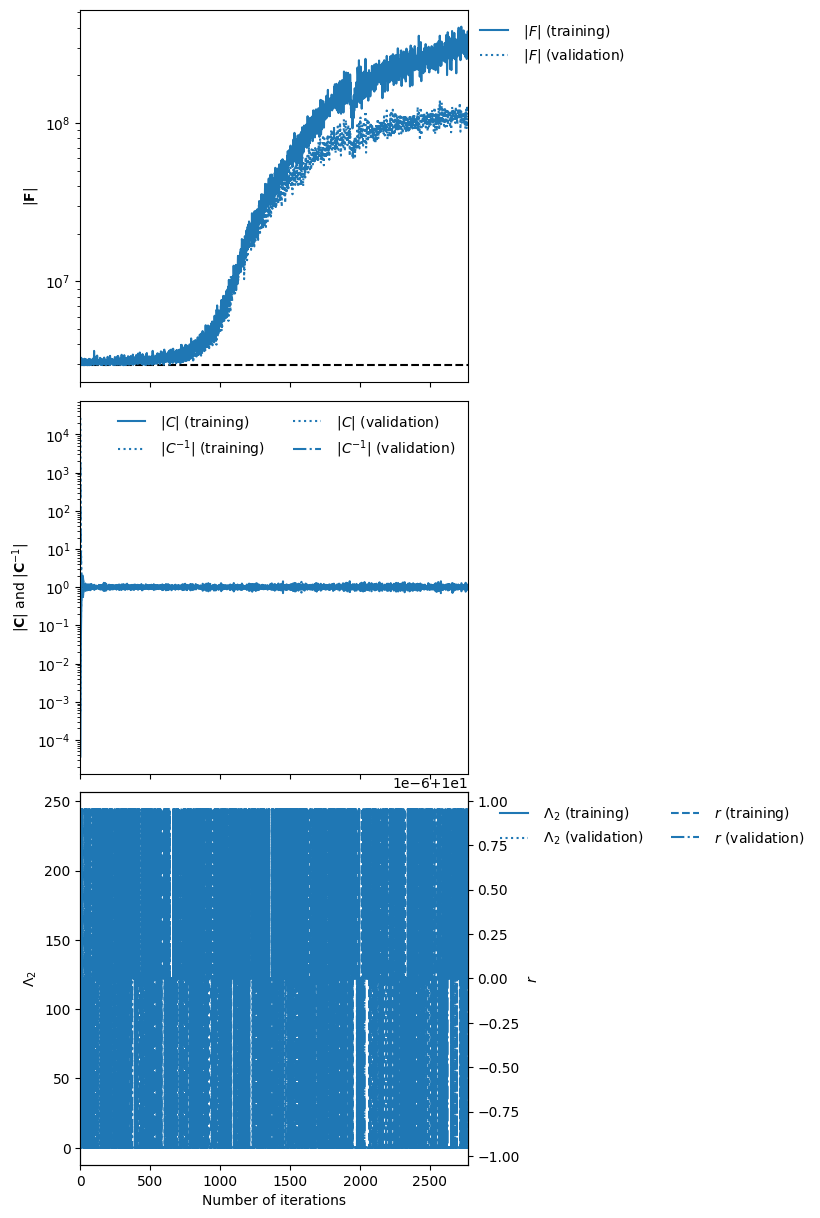

In [23]:
ax = IMNN.plot(expected_detF=jnp.linalg.det(mymoped.F))
ax[0].set_yscale("log")

In [24]:
IMNN.F, mymoped.F

(Array([[17941.377 ,  3704.544 ],
        [ 3704.5771,  7620.2715]], dtype=float32),
 Array([[16165.613 ,  6566.3594],
        [ 6566.3926,  2849.7327]], dtype=float32))

In [25]:
jnp.linalg.det(IMNN.F) / jnp.linalg.det(mymoped.F)

Array(41.687588, dtype=float32)

In [18]:
#@title fisher code
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_fisher_ellipse(fisher_matrix, mean=None, ax=None, color='blue', 
                        alpha=1.0, linestyle='-',
                       label=""):
    """
    Plots a Fisher information matrix ellipse.

    Parameters:
        fisher_matrix (numpy.ndarray): Fisher information matrix.
        mean (numpy.ndarray, optional): Mean vector. Defaults to None, in which case the ellipse will be centered at (0, 0).
        ax (matplotlib.axes.Axes, optional): Axes to plot on. If not provided, a new figure will be created.
        color (str, optional): Color of the ellipse. Defaults to 'blue'.
        alpha (float, optional): Transparency of the ellipse. Defaults to 0.5.
        linestyle (str, optional): Linestyle of the ellipse. Defaults to '-'.

    Returns:
        matplotlib.axes.Axes: Axes object with the ellipse plotted.
    """
    if ax is None:
        _, ax = plt.subplots()

    # Invert the Fisher information matrix to get the covariance matrix
    covariance_matrix = np.linalg.inv(fisher_matrix)

    # Calculate eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    # Calculate ellipse angle
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # If mean is provided, set the center of the ellipse accordingly
    if mean is not None:
        center = mean
    else:
        center = np.zeros_like(covariance_matrix.shape[0])

    # Create ellipse for 1-sigma contour
    ellipse = Ellipse(xy=center,
                      width=2 * np.sqrt(eigenvalues[0]),
                      height=2 * np.sqrt(eigenvalues[1]),
                      angle=angle,
                      edgecolor=color,
                      linestyle=linestyle,
                      facecolor='none',
                      alpha=alpha,
                      label=label)

    # Create ellipse for 2-sigma contour
    ellipse2 = Ellipse(xy=center,
                       width=2 * 2 * np.sqrt(eigenvalues[0]),
                       height=2 * 2 * np.sqrt(eigenvalues[1]),
                       angle=angle,
                       edgecolor=color,
                       linestyle=linestyle,
                       facecolor='none',
                       alpha=alpha)

    ax.add_patch(ellipse)
    ax.add_patch(ellipse2)
    #ax.set_aspect('equal', 'box')
    ax.autoscale()
    return ax

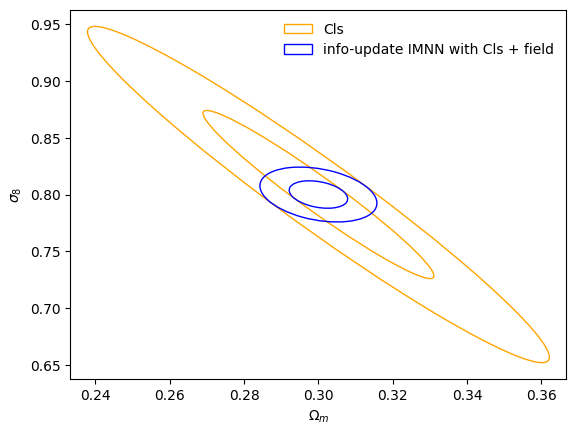

In [28]:
mean = θ_fid # Example mean vector

fishers = [mymoped.F, IMNN.F]
colours =["orange", "blue"]
labels = ["Cls", "info-update IMNN with Cls + field"]

for i,f in enumerate(fishers): 
    if i==0:
        ax = plot_fisher_ellipse(f, mean=mean, color=colours[i], label=labels[i])
    else:
        plot_fisher_ellipse(f, mean=mean, ax=ax, color=colours[i], label=labels[i])

plt.legend(framealpha=0.0)

plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$\sigma_8$')
#plt.title('Fisher Information Matrix Ellipse')

#plt.grid(True)
plt.show()

In [32]:
IMNN.invF

Array([[ 6.1956249e-05, -3.0119616e-05],
       [-3.0119885e-05,  1.4587150e-04]], dtype=float32)

In [40]:
def get_estimate(IMNN, d):

    @jax.jit
    def single_element(d):
        return IMNN.θ_fid + jnp.einsum(
            "ij,kj,kl,l->i",
            IMNN.invF,
            IMNN.dμ_dθ,
            IMNN.invC,
            IMNN.model(self.w, d) - IMNN.μ)

    @jax.jit
    def multiple_elements(d):

        def fn(d):
            return IMNN.model(IMNN.w, d)
        return IMNN.θ_fid + jnp.einsum(
            "ij,kj,kl,ml->mi",
            IMNN.invF,
            IMNN.dμ_dθ,
            IMNN.invC,
            jax.vmap(fn)(d) - IMNN.μ)

    #_check_statistics_set(self.invF, self.dμ_dθ, self.invC, self.μ)
    # check shape: array or graph ?
    if IMNN.dummy_graph_input is None:
      if len(d.shape) == 1:
          return single_element(d)
      else:
          return multiple_elements(d)
    else:
        return single_element(d)

In [41]:
fid[0].shape

(4, 128, 128)

In [46]:
get_estimate(IMNN, fid[59][jnp.newaxis, ...])

Array([[0.22528803, 0.73154145]], dtype=float32)

In [97]:
outdir

'/data101/makinen/lemur_sims/first_analysis/'

In [29]:
save_obj(IMNN.w, outdir + "imnn_weights/weights_info_update_0")

# load IMNN and compress the prior !

In [12]:
filters = (8,32,32,8)

model = InceptNet(filters=filters, mlp_features=[100, 100, 100])

lr_schedule = optax.exponential_decay(init_value=1e-3, 
                        transition_begin=150,
                        transition_steps=400, 
                        decay_rate=0.5, 
                        end_value=1e-6
                       )


optimiser = optax.adam(learning_rate=1e-3) # 1e-5


model_key = jr.PRNGKey(44)
key = jr.PRNGKey(55)
rng, key = jr.split(key)
input_shape = (4, N, N)


moped_statistic_long = dict(
        n_t = 150,
        mean_derivatives = mymoped.mu_dervs,
        covariance = mymoped.C,
        Fisher = mymoped.F,
        fid_summaries=fid_cls,
)



IMNN =  NoiseNumericalGradientIMNN(
    n_s=n_s, n_d=n_d, n_params=n_params, n_summaries=n_summaries,
    input_shape=input_shape, θ_fid=θ_fid, δθ=δθ, model=model,
    optimiser=optimiser, key_or_state=jnp.array(model_key),
    noise_simulator=(lambda rng, d: noise_simulator(
           rng, d)),
    fiducial=fid, 
    derivative=derv,
    validation_fiducial=val_fid,
    validation_derivative=val_derv,
    existing_statistic=moped_statistic,
    #no_invC=True, # True
    do_reg=True, # False
    #evidence=True # True
)

In [13]:
outdir

'/data101/makinen/lemur_sims/first_analysis/'

In [14]:
w = load_obj(outdir + "imnn_weights/weights_info_update_0.pkl")

In [15]:
IMNN.set_F_statistics(w = w, key=jr.PRNGKey(0))

In [16]:
# [[17941.377 ,  3704.544 ],
#         [ 3704.5771,  7620.2715]]
IMNN.F

Array([[17856.543 ,  3821.073 ],
       [ 3821.0623,  7315.3457]], dtype=float32)

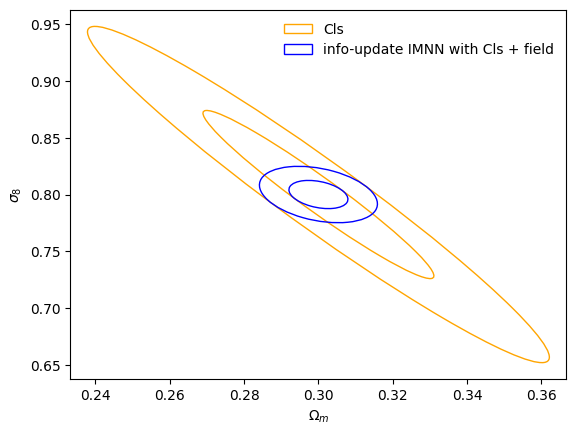

In [19]:
mean = θ_fid # Example mean vector

fishers = [mymoped.F, IMNN.F]
colours =["orange", "blue"]
labels = ["Cls", "info-update IMNN with Cls + field"]

for i,f in enumerate(fishers): 
    if i==0:
        ax = plot_fisher_ellipse(f, mean=mean, color=colours[i], label=labels[i])
    else:
        plot_fisher_ellipse(f, mean=mean, ax=ax, color=colours[i], label=labels[i])

plt.legend(framealpha=0.0)
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$\sigma_8$')
plt.show()

In [20]:
# pull in prior 
prior_sims = jnp.load(outdir + "prior_tomo_L_500_N_128_Nz_512_LPT2.npy")




In [23]:
key = jr.PRNGKey(49)
noisekeys = jr.split(key, num=prior_sims.shape[0])

# add in noise
prior_sims = jax.vmap(noise_simulator)(noisekeys, prior_sims)

In [24]:
# now compute Cls 

(5000, 4, 128, 128)